# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

In [3]:
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

In [4]:
# Define the 3D coordinates of the chessboard corners in the world coordinate system
chessboard_size = (9, 6)
origin_point = [0,0]
square_size = 0.047  # Assumiimgng each square size is 1 unit
object_points = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
object_points[:,:2] = (np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) -np.array(origin_point))* square_size

# Loading of Data

Text(0.5, 1.0, 'Chest Cam')

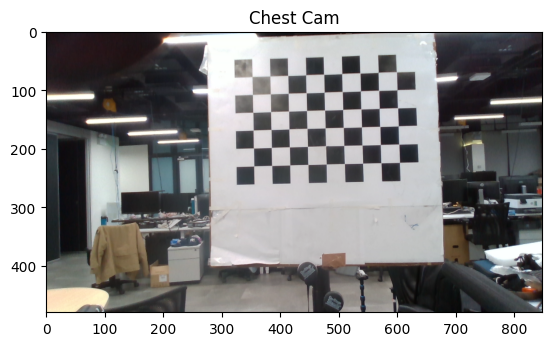

In [5]:
# Chest Cam

# Load the image containing the chessboard
chest_img = cv2.imread('calib_imgs/240124_chest_1m.png')

# Convert the image to grayscale
chest_gray = cv2.cvtColor(chest_img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
chest_ret, chest_corners = cv2.findChessboardCorners(chest_gray, chessboard_size, None)

# Display image
chest_disp = cv2.cvtColor(chest_img, cv2.COLOR_BGR2RGB)

plt.imshow(chest_disp)
plt.title('Chest Cam')

Text(0.5, 1.0, 'Left Eye Cam')

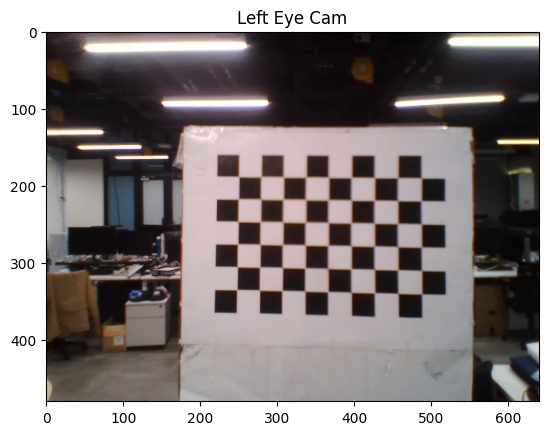

In [6]:
# Left Eye Cam

# Load the image containing the chessboard
left_img = cv2.imread('calib_imgs/240124_left_1m.png')

# Convert the image to grayscale
left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
left_ret, left_corners = cv2.findChessboardCorners(left_gray, chessboard_size, None)

# Display image
left_disp = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

plt.imshow(left_disp)
plt.title('Left Eye Cam')

Text(0.5, 1.0, 'Right Eye Cam')

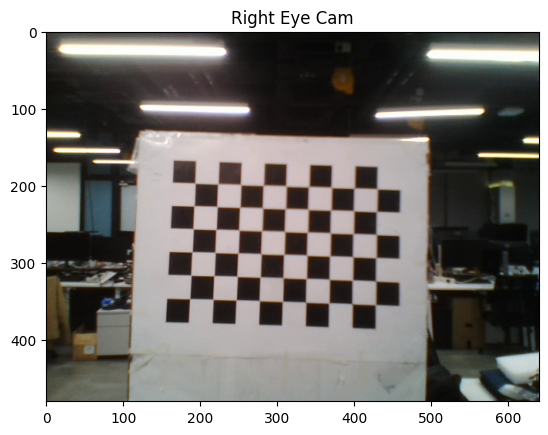

In [7]:
# Right Eye Cam

# Load the image containing the chessboard
right_img = cv2.imread('calib_imgs/240124_right_1m_move.png')

# Convert the image to grayscale
right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
right_ret, right_corners = cv2.findChessboardCorners(right_gray, chessboard_size, None)

# Display image
right_disp = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

plt.imshow(right_disp)
plt.title('Right Eye Cam')

# Extrinsic Camera Matrix

Chest Cam Extrinsic Matrix
[[ 0.99906007  0.02315209  0.03664641 -0.11240958]
 [-0.02439848  0.9991261   0.03393758 -0.25166131]
 [-0.03582866 -0.03479979  0.99875186  0.92523168]]


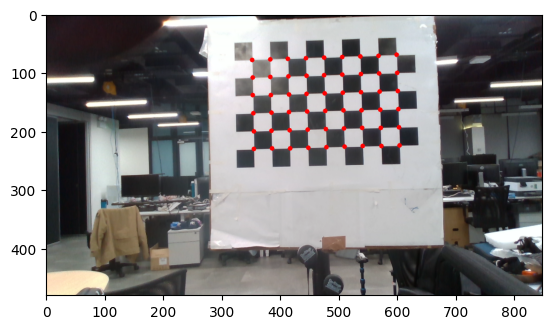

In [8]:
# Chest Cam

# Estimate the extrinsic matrix
retval, rvec, tvec = cv2.solvePnP(object_points, chest_corners, chest_cam_camera_mtx, chest_cam_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Create the extrinsic matrix
chest_extrinsic_matrix = np.hstack((rotation_matrix, tvec))
chest_homo_extrinsic_matrix = np.vstack((np.hstack((rotation_matrix, tvec)), np.array([0,0,0,1])))

print('Chest Cam Extrinsic Matrix')
print(chest_extrinsic_matrix)

# Project Image
points_3d = object_points
R = rotation_matrix
t = tvec

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, chest_cam_camera_mtx, chest_cam_dist_coef)

# Draw projected points on the image
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i, 0]
    chest_disp2 = cv2.circle(chest_disp, (int(x), int(y)), 4, (255, 0, 0), -1)

plt.imshow(chest_disp2)

Left Eye Cam Extrinsic Matrix
[[ 0.99847005 -0.01032446  0.05432287 -0.0951272 ]
 [ 0.00770856  0.99881057  0.0481458  -0.05434554]
 [-0.05475534 -0.04765339  0.99736202  0.91401076]]


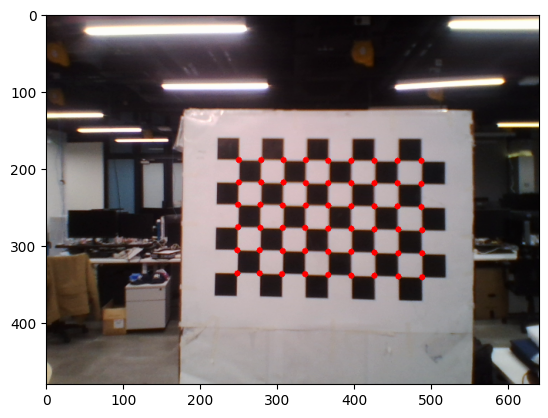

In [9]:
# Left Eye Cam

# Estimate the extrinsic matrix
retval, rvec, tvec = cv2.solvePnP(object_points, left_corners, left_eye_camera_mtx, left_eye_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Create the extrinsic matrix
left_extrinsic_matrix = np.hstack((rotation_matrix, tvec))

print('Left Eye Cam Extrinsic Matrix')
print(left_extrinsic_matrix)

# Project Image
points_3d = object_points
R = rotation_matrix
t = tvec
t = np.array([[-0.26],[-0.13332512],[0.98441858]])

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, left_eye_camera_mtx, left_eye_dist_coef)

# Draw projected points on the image
left_temp = copy.deepcopy(left_disp)
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i, 0]
    cv2.circle(left_temp, (int(x), int(y)), 4, (255, 0, 0), -1)

plt.imshow(left_temp)

Right Eye Cam Extrinsic Matrix
[[ 0.99898934 -0.03217298  0.0313878  -0.1794361 ]
 [ 0.03052076  0.99819258  0.05176925 -0.03894395]
 [-0.03299664 -0.05075895  0.99816569  0.91854151]]


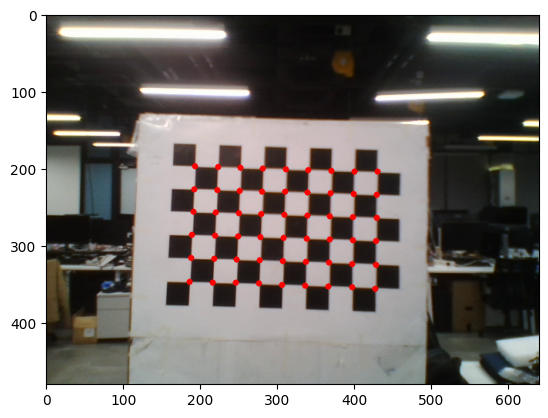

In [10]:
# Right Eye Cam

# Estimate the extrinsic matrix
retval, rvec, tvec = cv2.solvePnP(object_points, right_corners, right_eye_camera_mtx, right_eye_dist_coef)

# Convert the rotation vector to a rotation matrix
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Create the extrinsic matrix
right_extrinsic_matrix = np.hstack((rotation_matrix, tvec))

print('Right Eye Cam Extrinsic Matrix')
print(right_extrinsic_matrix)

# Project Image
points_3d = object_points
R = rotation_matrix
t = tvec

# Undistort the points
points_2d_undistorted, _ = cv2.projectPoints(points_3d, rvec, tvec, right_eye_camera_mtx, right_eye_dist_coef)

# Draw projected points on the image
for i in range(points_2d_undistorted.shape[0]):
    x, y = points_2d_undistorted[i, 0]
    right_disp2 = cv2.circle(right_disp, (int(x), int(y)), 4, (255, 0, 0), -1)

plt.imshow(right_disp2)